# Analyse av dataen fra Aneo

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Load the Datasets

In [3]:
# Load energy data
energy_df = pd.read_csv('../data/energy_import_export.csv')

# Load solar self-consumption data
solar_df = pd.read_csv('../data/solar_self_consumption_main_building.csv')

# Load meteorological data
met_df = pd.read_csv('../data/met_data.csv')

In [4]:
# drop columns "Unnamed: 0"
solar_df = solar_df.drop(columns=['Unnamed: 0'])
solar_df.head()

,starting_at,solar_consumption
0,2023-07-01,0.002687
1,2023-07-01 01:00:00,0.002750
2,2023-07-01 02:00:00,0.002937
3,2023-07-01 03:00:00,0.003062
4,2023-07-01 04:00:00,0.000035


## 2. Pre-Processing

### 2.1 Convert Timestamps to datetime objects

In [5]:
# Convert timestamp columns to datetime
energy_df['Tidspunkt'] = pd.to_datetime(energy_df['Tidspunkt'], format="mixed")
solar_df['starting_at'] = pd.to_datetime(solar_df['starting_at'], format='mixed')

# remove utc from the time string
met_df['starting_at'] = met_df['starting_at'].str.split('+').str[0]
met_df['starting_at'] = pd.to_datetime(met_df['starting_at'], format='mixed')

### 2.2 Rename Columns for Consistency

In [6]:
energy_df.rename(columns={
    'Energikilde': 'energy_source',
    'Retning': 'direction',
    'Målernavn': 'meter_name',
    'Måler-Id': 'meter_id',
    'Verdi': 'value',
    'Tidspunkt': 'timestamp'
}, inplace=True)


solar_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)
met_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)

### 2.3 Map Property IDs to Meter IDs

In [7]:
meter_property_mapping = {
    '707057500042745649': 10724, #main building
    '707057500038344962': 10703, # building A
    '707057500085390523': 4462, # building B
    '707057500042201572': 4746 # building C
}
id_to_name_property_mapping= {
    10724: 'Main Building',
    10703: 'Building A',
    4462: 'Building B',
    4746: 'Building C'
}
def get_name(id):
    return id_to_name_property_mapping[id]

energy_df['meter_id'] = energy_df['meter_id'].astype(str)
energy_df['meter_id'] = energy_df['meter_id'].str.strip()

energy_df['property_id'] = energy_df['meter_id'].map(meter_property_mapping)
energy_df['building'] = energy_df['property_id'].map(id_to_name_property_mapping)

energy_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703,building A
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746,building C
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724,main building
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462,building B
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724,main building


### 2.4 Merge/Create Dataframes

In [66]:
#A merge of all the meteorological data with the respective energy data
merged_df = pd.merge(energy_df, met_df, on=['property_id', 'timestamp'], how='left')

merged_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
0,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,19.80,2023-07-01,10703,building A,12.9,1.0,275.7,0.7,0.0
1,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,35.10,2023-07-01,4746,building C,15.2,3.9,247.0,0.2,0.0
2,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2023-07-01,10724,main building,13.6,1.6,251.5,0.5,0.0
3,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.44,2023-07-01,4462,building B,12.0,0.7,220.3,0.5,0.0
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.50,2023-07-01,10724,main building,13.6,1.6,251.5,0.5,0.0


In [67]:
# DataFrames with data for each of the reference buildings
building_A_df = merged_df[merged_df['building'] == 'Building A']
building_B_df = merged_df[merged_df['building'] == 'Building B']
building_C_df = merged_df[merged_df['building'] == 'Building C']

#Drop the export values in building B
building_B_df = building_B_df[building_B_df['direction'] == 'IMPORT']

#Set index to timestamp
building_A_df.set_index('timestamp', inplace=True)
building_B_df.set_index('timestamp', inplace=True)
building_C_df.set_index('timestamp', inplace=True)

building_B_df.head()

,energy_source,direction,meter_name,meter_id,value,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
timestamp,,,,,,,,,,,,
2023-07-01 00:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.44,4462,building B,12.0,0.7,220.3,0.5,0.0
2023-07-01 01:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,21.52,4462,building B,11.9,0.7,179.6,0.9,0.0
2023-07-01 02:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,26.16,4462,building B,11.4,0.6,164.3,0.9,0.0
2023-07-01 03:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.28,4462,building B,11.8,0.6,172.6,1.0,0.0
2023-07-01 04:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,24.32,4462,building B,12.1,0.4,197.8,1.0,0.0


In [68]:
#Check the shape of the reference buildings
print(building_A_df.shape)
print(building_B_df.shape)
print(building_C_df.shape)

(10367, 12)
(10367, 12)
(10367, 12)


In [71]:
#Check for missing values in the reference buildings
print("------------------Building A------------------")
print("total number of rows", building_A_df.shape[0])
print("rows missing weather data \n",building_A_df.isnull().sum())
print()

print("------------------Building B------------------")
print("total number of rows", building_B_df.shape[0])
print("rows missing weather data \n",building_B_df.isnull().sum())
print()

print("------------------Building C------------------")
print("total number of rows", building_C_df.shape[0])
print("rows missing weather data \n",building_C_df.isnull().sum())

------------------Building A------------------
total number of rows 10367
rows missing weather data 
 energy_source      0
direction          0
meter_name         0
meter_id           0
value              0
property_id        0
building           0
temperature       77
wind_speed        77
wind_direction    77
cloud_fraction    77
precipitation     77
dtype: int64

------------------Building B------------------
total number of rows 10367
rows missing weather data 
 energy_source      0
direction          0
meter_name         0
meter_id           0
value              0
property_id        0
building           0
temperature       77
wind_speed        77
wind_direction    77
cloud_fraction    77
precipitation     77
dtype: int64

------------------Building C------------------
total number of rows 10367
rows missing weather data 
 energy_source      0
direction          0
meter_name         0
meter_id           0
value              0
property_id        0
building           0
temperature    

In [72]:
#Fill missing values with interpolation
building_A_df = building_A_df.interpolate(method='time', limit_direction='both')
building_B_df = building_B_df.interpolate(method='time', limit_direction='both')
building_C_df = building_C_df.interpolate(method='time', limit_direction='both')

print("------------------Building C------------------")
print("total number of rows", building_C_df.shape[0])
print("rows missing weather data \n",building_C_df.isnull().sum())

------------------Building C------------------
total number of rows 10367
rows missing weather data 
 energy_source     0
direction         0
meter_name        0
meter_id          0
value             0
property_id       0
building          0
temperature       0
wind_speed        0
wind_direction    0
cloud_fraction    0
precipitation     0
dtype: int64


In [77]:
#Dataframes with the import and export data for the main building separately
main_building_import_df = merged_df[(merged_df['building'] == 'Main Building') & (merged_df['direction'] == 'IMPORT')]
main_building_export_df = merged_df[(merged_df['building'] == 'Main Building') & (merged_df['direction'] == 'EXPORT')]

#Set the timestamp as index
main_building_import_df.set_index('timestamp', inplace=True)
main_building_export_df.set_index('timestamp', inplace=True)

print("total number of rows", main_building_import_df.shape)
print("total number of rows", main_building_export_df.shape)
main_building_import_df.head()

total number of rows (10343, 12)
total number of rows (10343, 12)


,energy_source,direction,meter_name,meter_id,value,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
timestamp,,,,,,,,,,,,
2023-07-01 00:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,10724,main building,13.6,1.6,251.5,0.5,0.0
2023-07-01 01:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,10724,main building,13.2,2.0,246.5,0.4,0.0
2023-07-01 02:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,10724,main building,12.3,1.6,260.4,0.3,0.0
2023-07-01 03:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,10724,main building,11.9,0.6,285.0,0.9,0.0
2023-07-01 04:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,10724,main building,11.9,0.2,295.8,0.8,0.0


In [78]:
#Check for missing values

print("------------------Main Building Import------------------")
print("total number of rows", main_building_import_df.shape[0])
print("rows missing weather data \n",main_building_import_df.isnull().sum())
print()

print("------------------Main Building Export------------------")
print("total number of rows", main_building_export_df.shape[0])
print("rows missing weather data \n",main_building_export_df.isnull().sum())

------------------Main Building Import------------------
total number of rows 10343
rows missing weather data 
 energy_source      0
direction          0
meter_name         0
meter_id           0
value              0
property_id        0
building           0
temperature       77
wind_speed        77
wind_direction    77
cloud_fraction    77
precipitation     77
dtype: int64

------------------Main Building Export------------------
total number of rows 10343
rows missing weather data 
 energy_source      0
direction          0
meter_name         0
meter_id           0
value              0
property_id        0
building           0
temperature       77
wind_speed        77
wind_direction    77
cloud_fraction    77
precipitation     77
dtype: int64


In [79]:
#Fill missing values with interpolation
main_building_import_df = main_building_import_df.interpolate(method='time', limit_direction='both')
main_building_export_df = main_building_export_df.interpolate(method='time', limit_direction='both')

print("------------------Main Building Export------------------")
print("total number of rows", main_building_export_df.shape[0])
print("rows missing weather data \n",main_building_export_df.isnull().sum())

------------------Main Building Export------------------
total number of rows 10343
rows missing weather data 
 energy_source     0
direction         0
meter_name        0
meter_id          0
value             0
property_id       0
building          0
temperature       0
wind_speed        0
wind_direction    0
cloud_fraction    0
precipitation     0
dtype: int64


In [85]:
# We see that for every import there is a corresponding export. 
# Only one will have a non-zero value, the other will have a zero value.
#We make a new DataFrame with the difference between the import and export values
#When we merge this with the solar data we will get the net import/export values, which also is the total consumption
main_building_df = main_building_import_df.copy()
main_building_df['value'] = main_building_import_df['value'] - main_building_export_df['value']
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
timestamp,,,,,,,,,,,,
2023-07-01 00:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,10724,main building,13.6,1.6,251.5,0.5,0.0
2023-07-01 01:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,10724,main building,13.2,2.0,246.5,0.4,0.0
2023-07-01 02:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,10724,main building,12.3,1.6,260.4,0.3,0.0
2023-07-01 03:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,10724,main building,11.9,0.6,285.0,0.9,0.0
2023-07-01 04:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,10724,main building,11.9,0.2,295.8,0.8,0.0


In [86]:
#We merge the main building data with the solar data
main_building_df = pd.merge(main_building_df, solar_df, on='timestamp', how='left')

#Set index to timestamp
main_building_df.set_index('timestamp', inplace=True)

print(main_building_df.shape)
main_building_df.head()

(10346, 13)


,energy_source,direction,meter_name,meter_id,value,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption
timestamp,,,,,,,,,,,,,
2023-07-01 00:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687
2023-07-01 01:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750
2023-07-01 02:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937
2023-07-01 03:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062
2023-07-01 04:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035


In [87]:
#We check for missing values

print("------------------Main Building------------------")
print("total number of rows", main_building_df.shape[0])
print("rows missing solar data \n",main_building_df.isnull().sum())


------------------Main Building------------------
total number of rows 10346
rows missing solar data 
 energy_source          0
direction              0
meter_name             0
meter_id               0
value                  0
property_id            0
building               0
temperature            0
wind_speed             0
wind_direction         0
cloud_fraction         0
precipitation          0
solar_consumption    153
dtype: int64


In [88]:
#Fill missing values with interpolation
main_building_df = main_building_df.interpolate(method='time', limit_direction='both')

print("------------------Main Building------------------")
print("total number of rows", main_building_df.shape[0])
print("rows missing solar data \n",main_building_df.isnull().sum())

------------------Main Building------------------
total number of rows 10346
rows missing solar data 
 energy_source        0
direction            0
meter_name           0
meter_id             0
value                0
property_id          0
building             0
temperature          0
wind_speed           0
wind_direction       0
cloud_fraction       0
precipitation        0
solar_consumption    0
dtype: int64


In [91]:
#Calculate the total consumption for the main building
main_building_df['total_consumption'] = main_building_df['value'] + main_building_df['solar_consumption']

main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
timestamp,,,,,,,,,,,,,,
2023-07-01 00:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
2023-07-01 01:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2023-07-01 02:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
2023-07-01 03:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
2023-07-01 04:00:00,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


We have now preprocessed 6 dataframes:\
**- Building_A_df**: Contains the energy data with met data for building A\
**- Building_B_df**: Contains the energy data with met data for building B\
**- Building_C_df**: Contains the energy data with met data for building C\
**- main_building_import_df**: All the import data for the main building with met data\
**- main_building_export_df**: All the export data for the main building with met data\
**- main_building_df**: All data for the main building where value is net import, with met data, with solar consumption data and a calculated total consumption net import + solar consumption\

## 3. Analysis

### 3.1 Comparing the consumption and import of the main building with the references

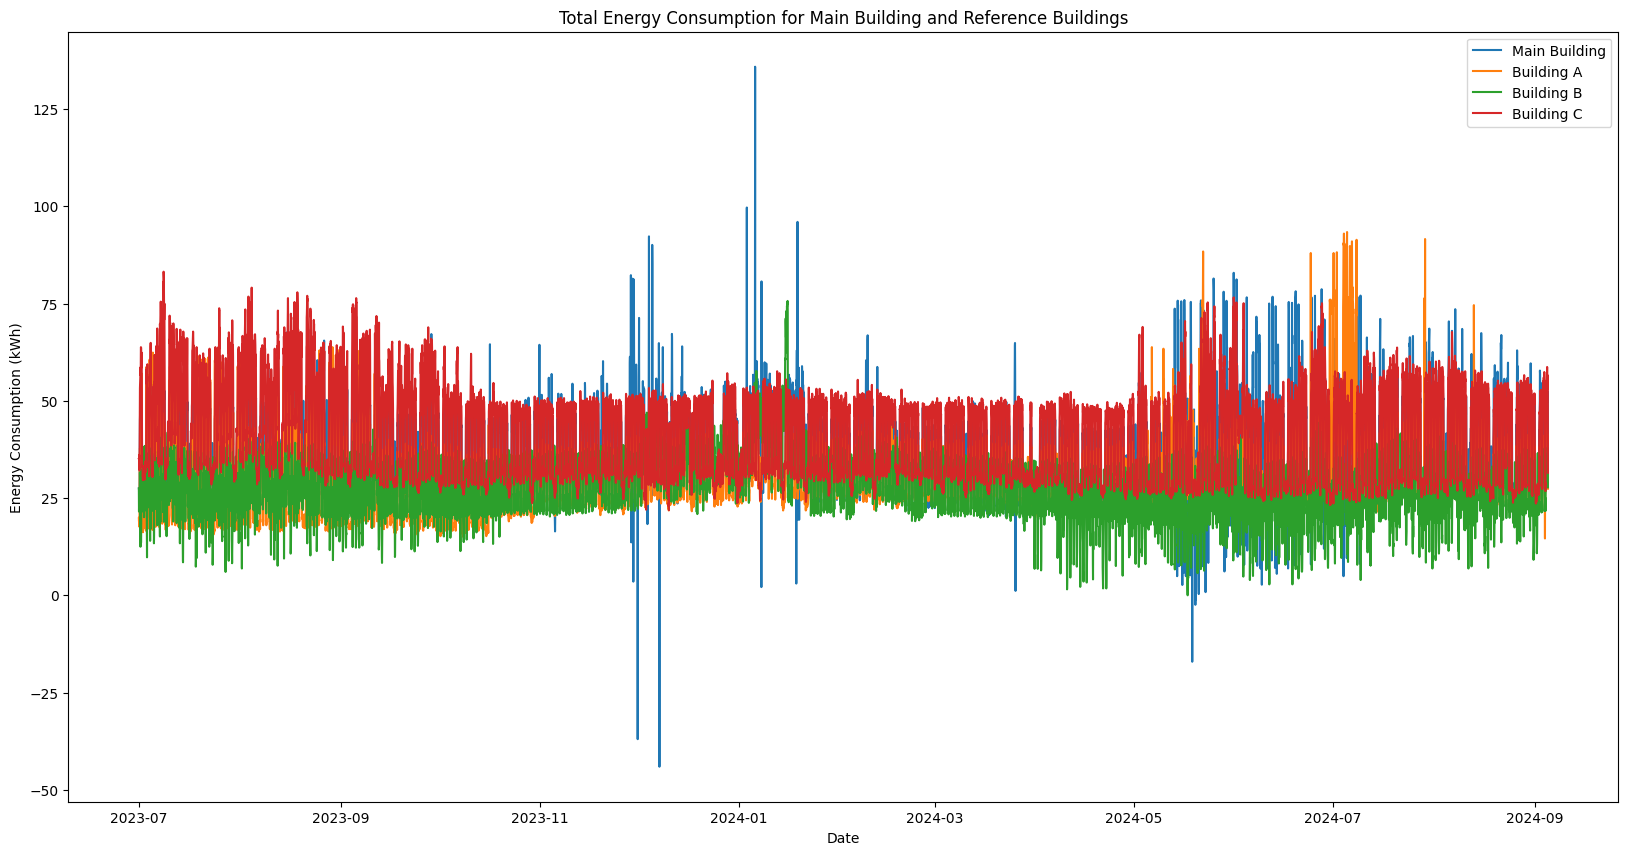

In [96]:
#Lineplot of all the buildings' consumption

plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='total_consumption', label='Main Building')  
sns.lineplot(data=building_A_df, x='timestamp', y='value', label='Building A')  
sns.lineplot(data=building_B_df, x='timestamp', y='value', label='Building B')  
sns.lineplot(data=building_C_df, x='timestamp', y='value', label='Building C')  
plt.title('Total Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

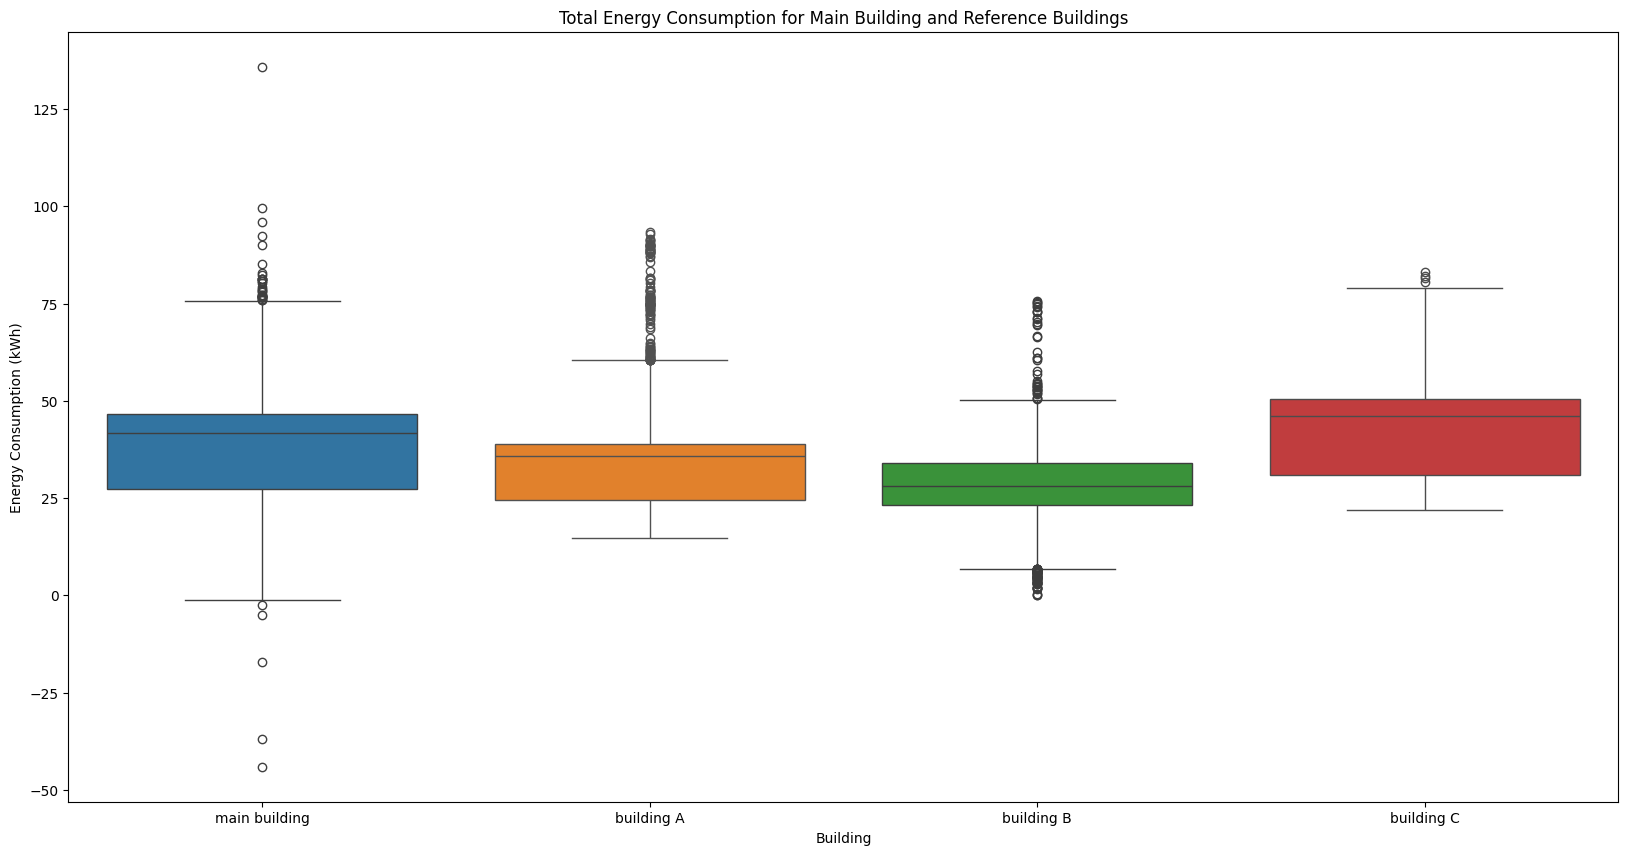

Mean energy consumption for main building:  38.51334440241726 Median:  41.73231461867688
Mean energy consumption for building A:  33.30788656313302 Median:  35.8
Mean energy consumption for building B:  28.21717565351596 Median:  28.16
Mean energy consumption for building C:  43.02215105623613 Median:  46.2


In [146]:
#Boxplot of the consumptions for the buildings
plt.figure(figsize=(20,10))
sns.boxplot(data=main_building_df, x='building', y='total_consumption')
sns.boxplot(data=building_A_df, x='building', y='value')
sns.boxplot(data=building_B_df, x='building', y='value')
sns.boxplot(data=building_C_df, x='building', y='value')
plt.title('Total Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()

'''
The main building has a higher average energy consumption compared to the reference buildings.
Its peaks are also higher than the reference buildings.
'''

print("Mean energy consumption for main building: ", main_building_df['total_consumption'].mean(), "Median: ", main_building_df['total_consumption'].median())
print("Mean energy consumption for building A: ", building_A_df['value'].mean(), "Median: ", building_A_df['value'].median())
print("Mean energy consumption for building B: ", building_B_df['value'].mean(), "Median: ", building_B_df['value'].median())
print("Mean energy consumption for building C: ", building_C_df['value'].mean(), "Median: ", building_C_df['value'].median())

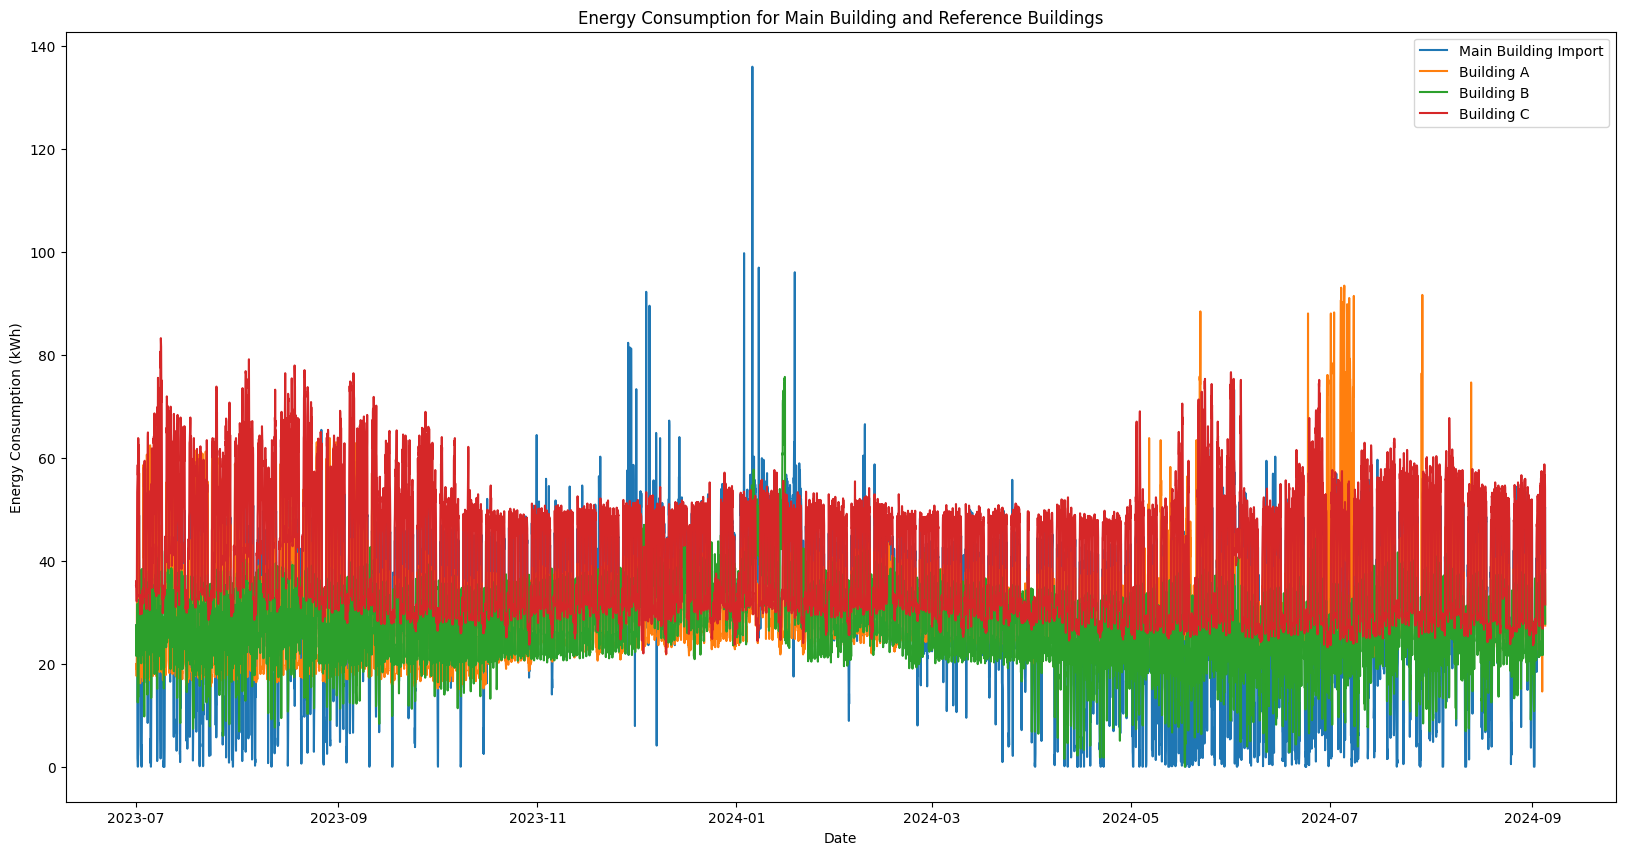

In [98]:
#Lets do the same again, but only look at the import data for the main building

plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_import_df, x='timestamp', y='value', label='Main Building Import')
sns.lineplot(data=building_A_df, x='timestamp', y='value', label='Building A')
sns.lineplot(data=building_B_df, x='timestamp', y='value', label='Building B')
sns.lineplot(data=building_C_df, x='timestamp', y='value', label='Building C')
plt.title('Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()


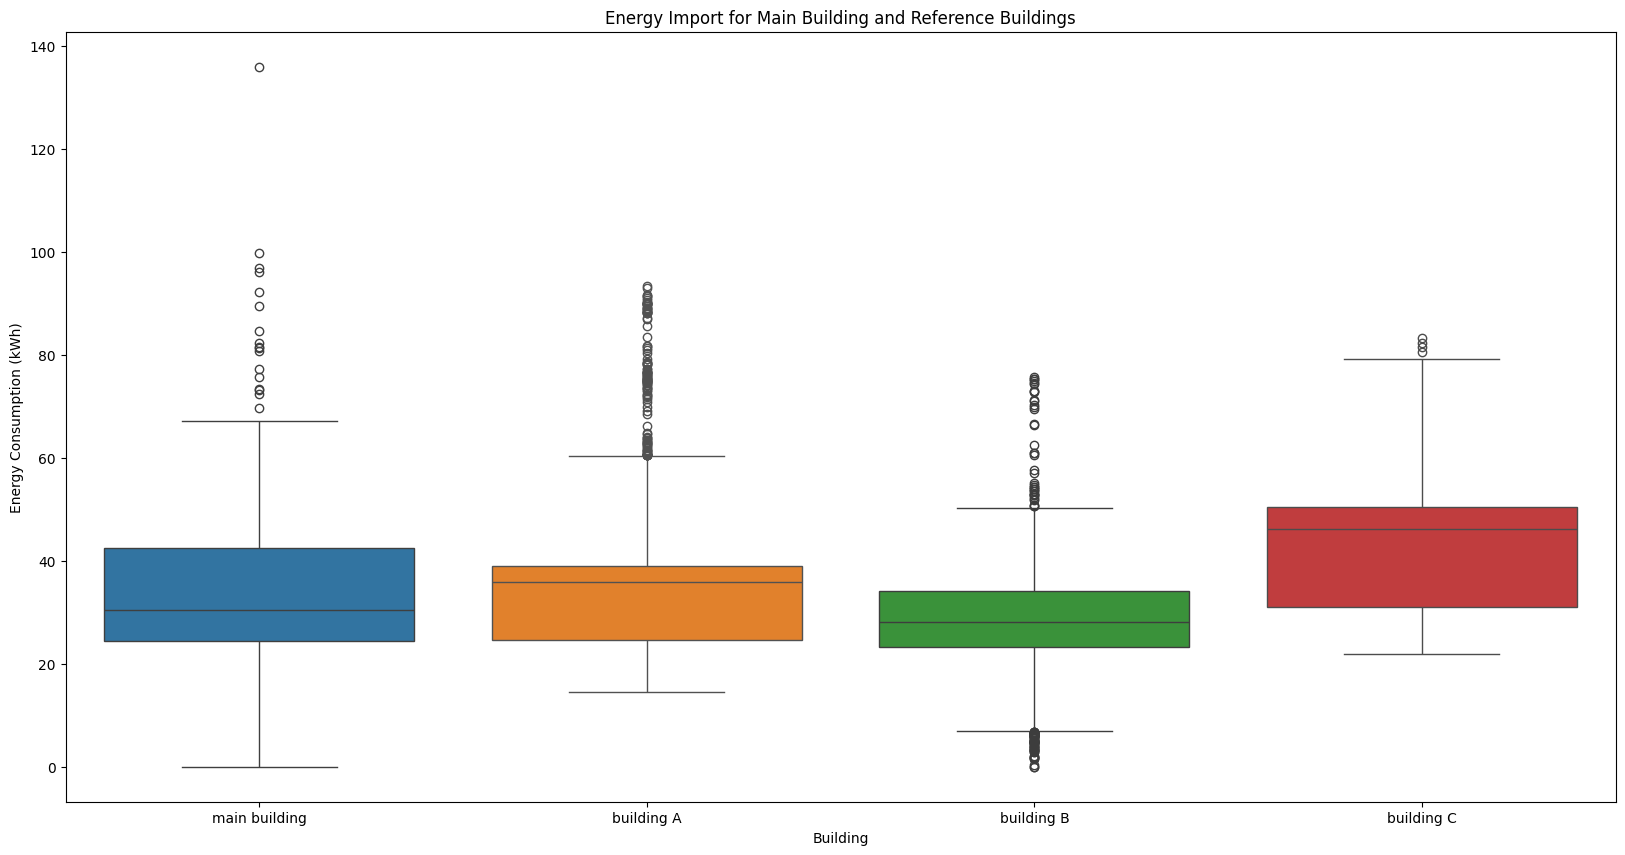

Mean energy import for main building:  31.012764353373285 Median:  30.5
Mean energy import for building A:  33.30788656313302 Median:  35.8
Mean energy import for building B:  28.21717565351596 Median:  28.16
Mean energy import for building C:  43.02215105623613 Median:  46.2


In [147]:
#And the boxplot

plt.figure(figsize=(20,10))
sns.boxplot(data=main_building_import_df, x='building', y='value')
sns.boxplot(data=building_A_df, x='building', y='value')
sns.boxplot(data=building_B_df, x='building', y='value')
sns.boxplot(data=building_C_df, x='building', y='value')
plt.title('Energy Import for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()

'''
We see now that their average energy import is on the lower end compared to the reference buildings.
The peaks still remain the same though.
'''
print("Mean energy import for main building: ", main_building_df['value'].mean(), "Median: ", main_building_df['value'].median())
print("Mean energy import for building A: ", building_A_df['value'].mean(), "Median: ", building_A_df['value'].median())
print("Mean energy import for building B: ", building_B_df['value'].mean(), "Median: ", building_B_df['value'].median())
print("Mean energy import for building C: ", building_C_df['value'].mean(), "Median: ", building_C_df['value'].median())

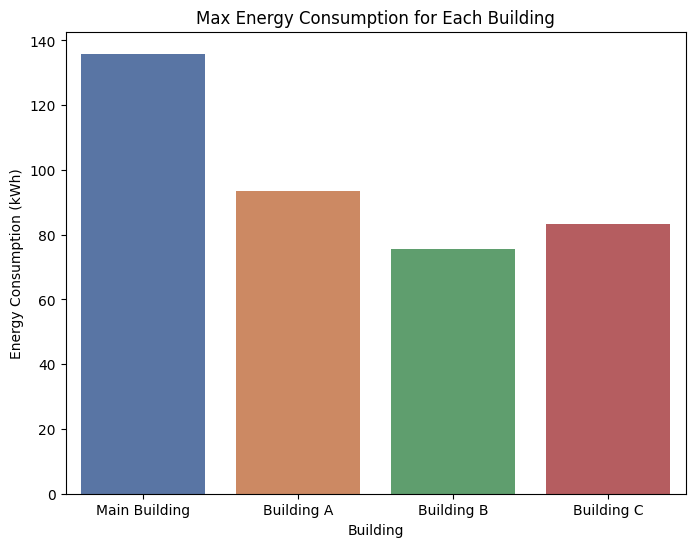

In [136]:
#Bar Plot of the max value for each building

# Find the maximum value for each building
max_main_building = main_building_df['total_consumption'].max()
max_building_A = building_A_df['value'].max()
max_building_B = building_B_df['value'].max()
max_building_C = building_C_df['value'].max()

# Create a list of the max values and corresponding labels
max_values = [max_main_building, max_building_A, max_building_B, max_building_C]
building_labels = ['Main Building', 'Building A', 'Building B', 'Building C']

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=building_labels, y=max_values, hue=building_labels, palette='deep')

# Add labels and title
plt.title('Peak Energy Consumption for Each Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()

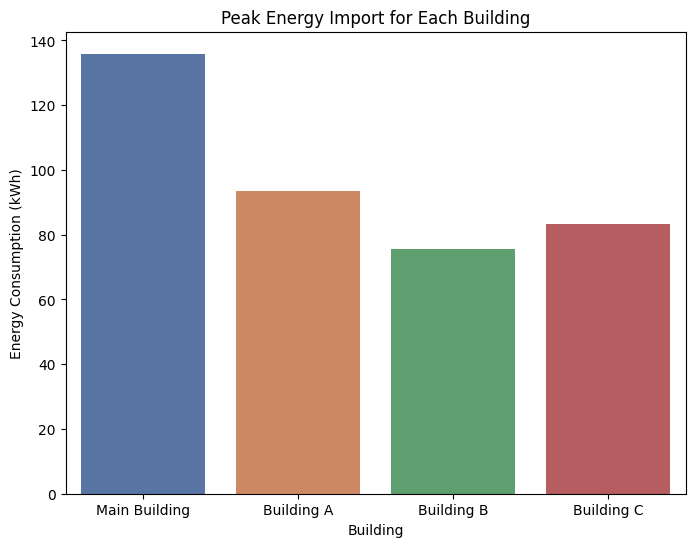

In [137]:
#Bar Plot of the max import for each building

#The max net_import is the same as the max import
max_import_main_building = main_building_df['value'].max()

# Create a list of the max values and corresponding labels
max_values = [max_import_main_building, max_building_A, max_building_B, max_building_C]
building_labels = ['Main Building', 'Building A', 'Building B', 'Building C']

# Plot the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=building_labels, y=max_values, hue=building_labels, palette='deep')

# Add labels and title
plt.title('Peak Energy Import for Each Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()


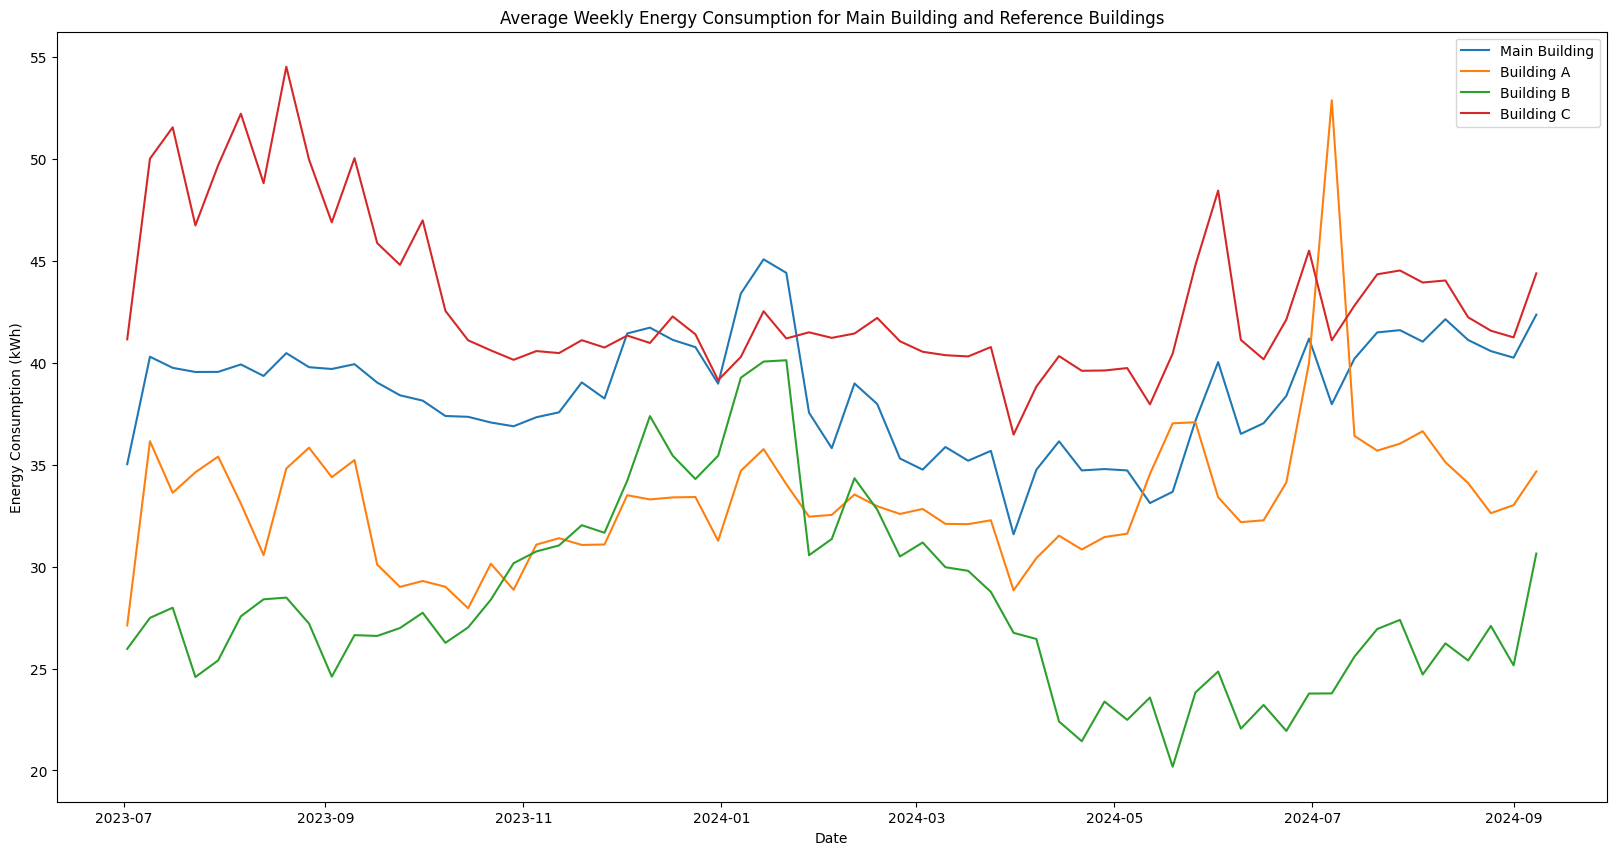

In [124]:
#We try to look at weekly data instead by grouping the data by week and taking the mean
main_building_weekly_df = main_building_df["total_consumption"].resample('W').mean().reset_index()
building_A_weekly_df = building_A_df["value"].resample('W').mean().reset_index()
building_B_weekly_df = building_B_df["value"].resample('W').mean().reset_index()
building_C_weekly_df = building_C_df["value"].resample('W').mean().reset_index()

#Lineplot of the monthly data
plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_weekly_df, x='timestamp', y='total_consumption', label='Main Building')
sns.lineplot(data=building_A_weekly_df, x='timestamp', y='value', label='Building A')
sns.lineplot(data=building_B_weekly_df, x='timestamp', y='value', label='Building B')
sns.lineplot(data=building_C_weekly_df, x='timestamp', y='value', label='Building C')
plt.title('Average Weekly Energy Consumption for Main Building and Reference Buildings')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()

### 3.2 Comparing the Main Building Throughout the period

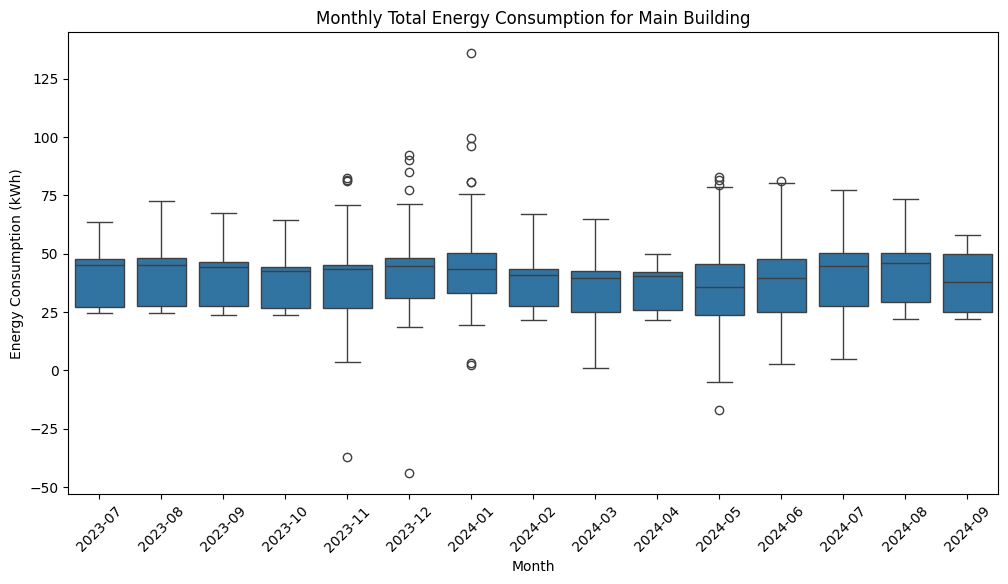

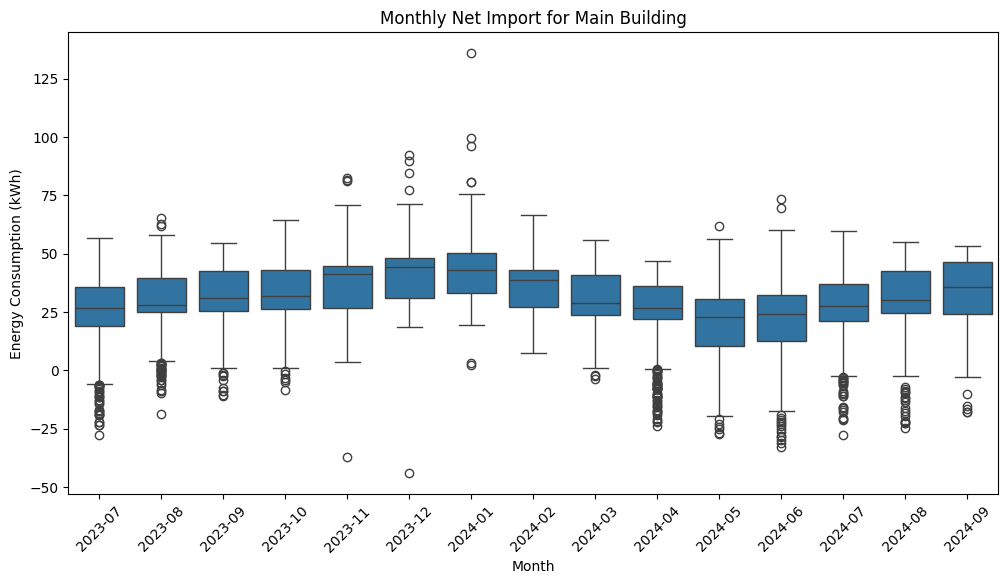

In [119]:
#We want to look at the monthly differences in consumption for the main building
#That is a box plot for each month

# Extract the month from the datetime index
main_building_df['month'] = main_building_df.index.to_period('M')

# Create the boxplot of total consumption by month
plt.figure(figsize=(12, 6))
sns.boxplot(data=main_building_df, x='month', y='total_consumption')
plt.title('Monthly Total Energy Consumption for Main Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Create the boxplot of net import by month
plt.figure(figsize=(12, 6))
sns.boxplot(data=main_building_df, x='month', y='value')
plt.title('Monthly Net Import for Main Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

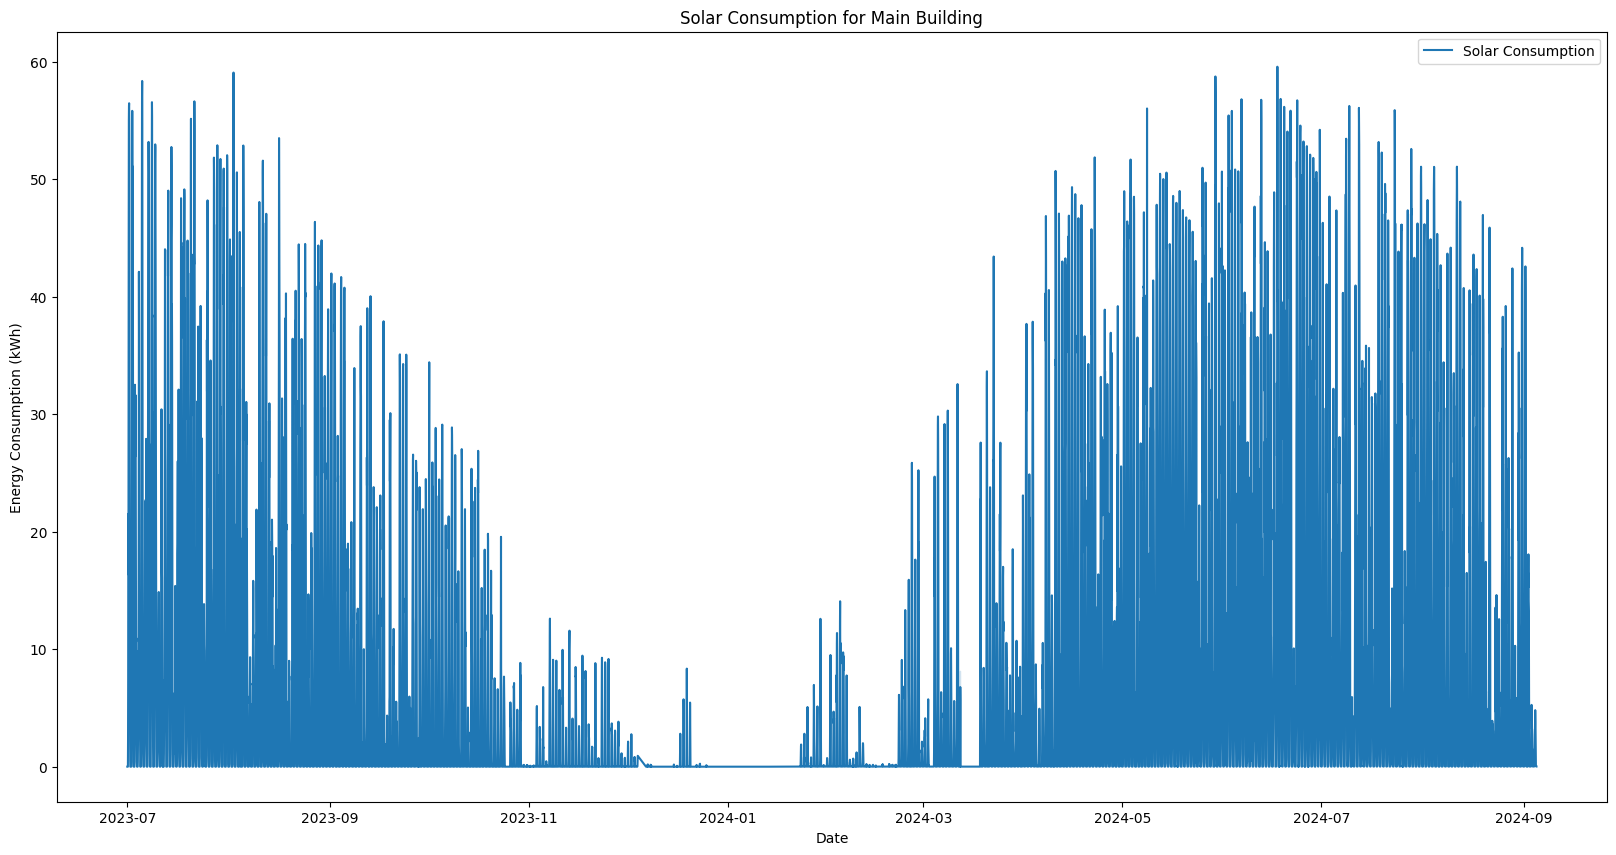

In [120]:
#We want to plot the solar consumption for the main building

plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='solar_consumption', label='Solar Consumption')
plt.title('Solar Consumption for Main Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()



### 3.3 Correlations with Meteorological Data

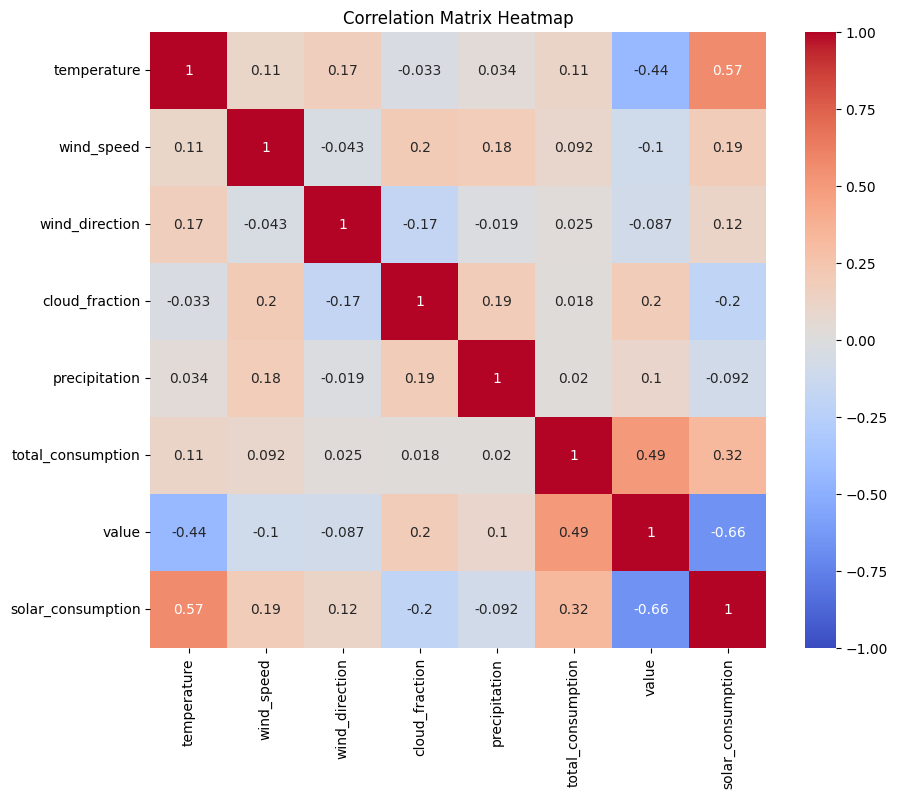

In [140]:
#We create a Correlation Matrix Heatmap for the main building

# Generate the correlation matrix
correlation_matrix_solar = main_building_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "total_consumption", "value", "solar_consumption"]].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix_solar, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

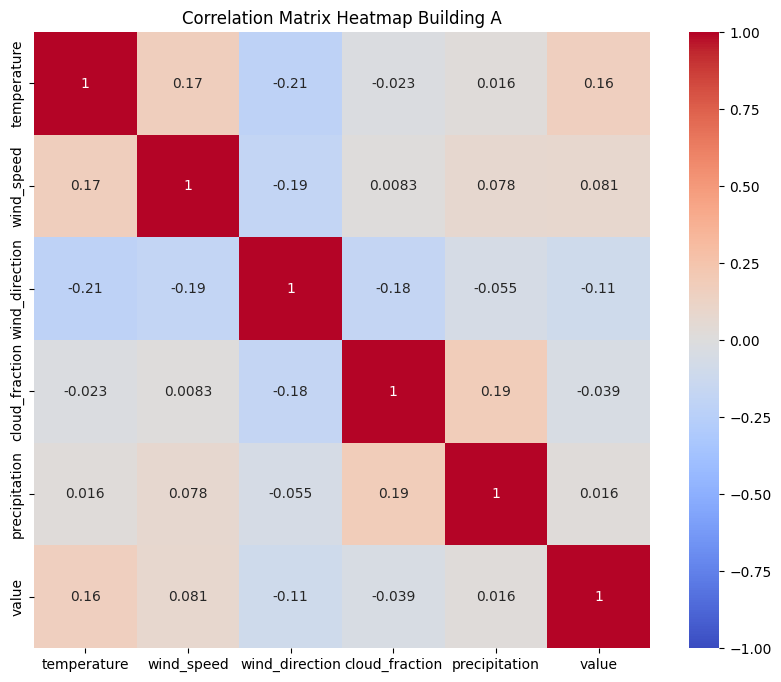

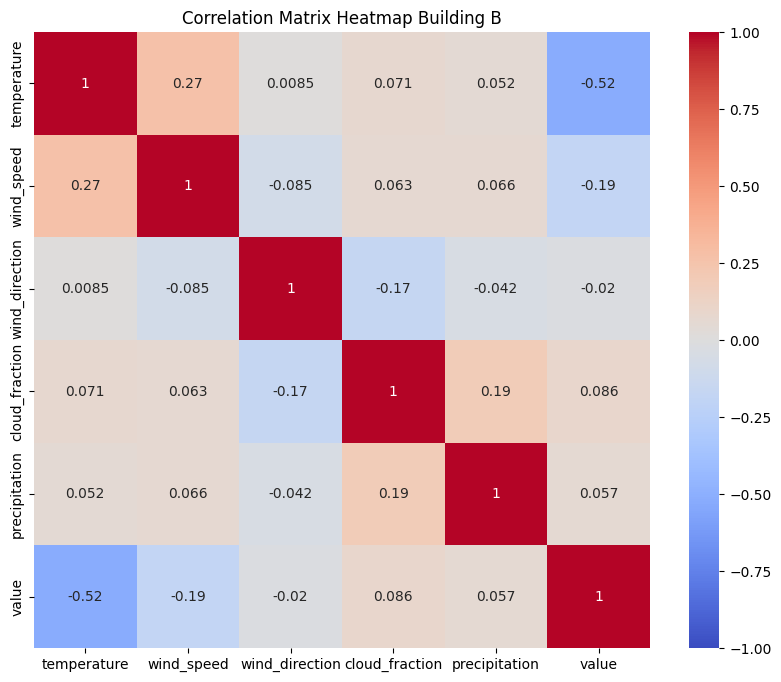

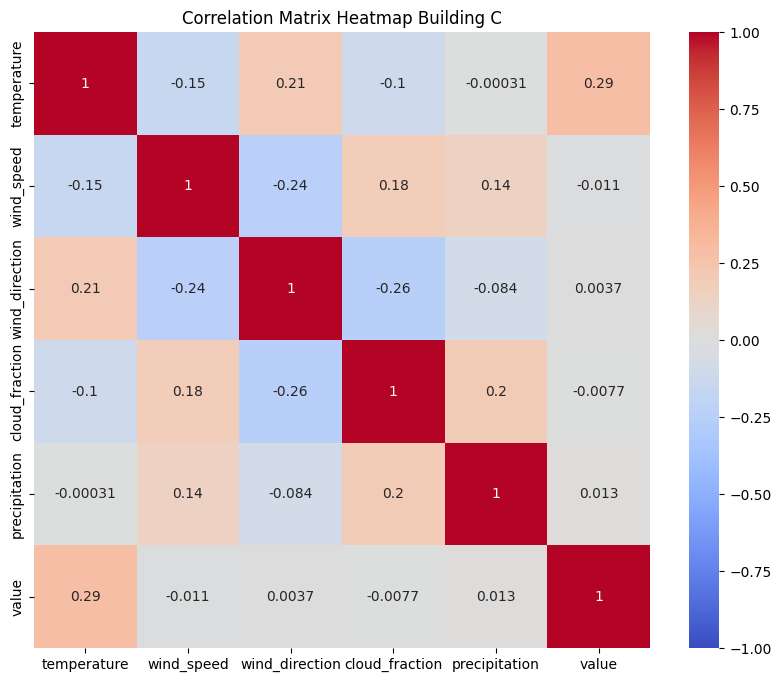

'\nThere seems to be a correlations with consumption(import) and temperature for all buildings.\nFor the Main Building the Solar_consumption seems to negate the correlation with temperature when it comes to total_consumption.\n'

In [141]:
#We check if there are any correlations for the other buildings

# Generate the correlation matrix
correlation_matrix_A = building_A_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "value"]].corr()
correlation_matrix_B = building_B_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "value"]].corr()
correlation_matrix_C = building_C_df[["temperature", "wind_speed", "wind_direction", "cloud_fraction", "precipitation", "value"]].corr()

#Building A
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_A, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap Building A")
plt.show()

#Building B
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_B, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap Building B")
plt.show()

#Building C
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_C, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix Heatmap Building C")
plt.show()

'''
There seems to be a correlations with consumption(import) and temperature for all buildings.
For the Main Building the Solar_consumption seems to negate the correlation with temperature when it comes to total_consumption.
'''

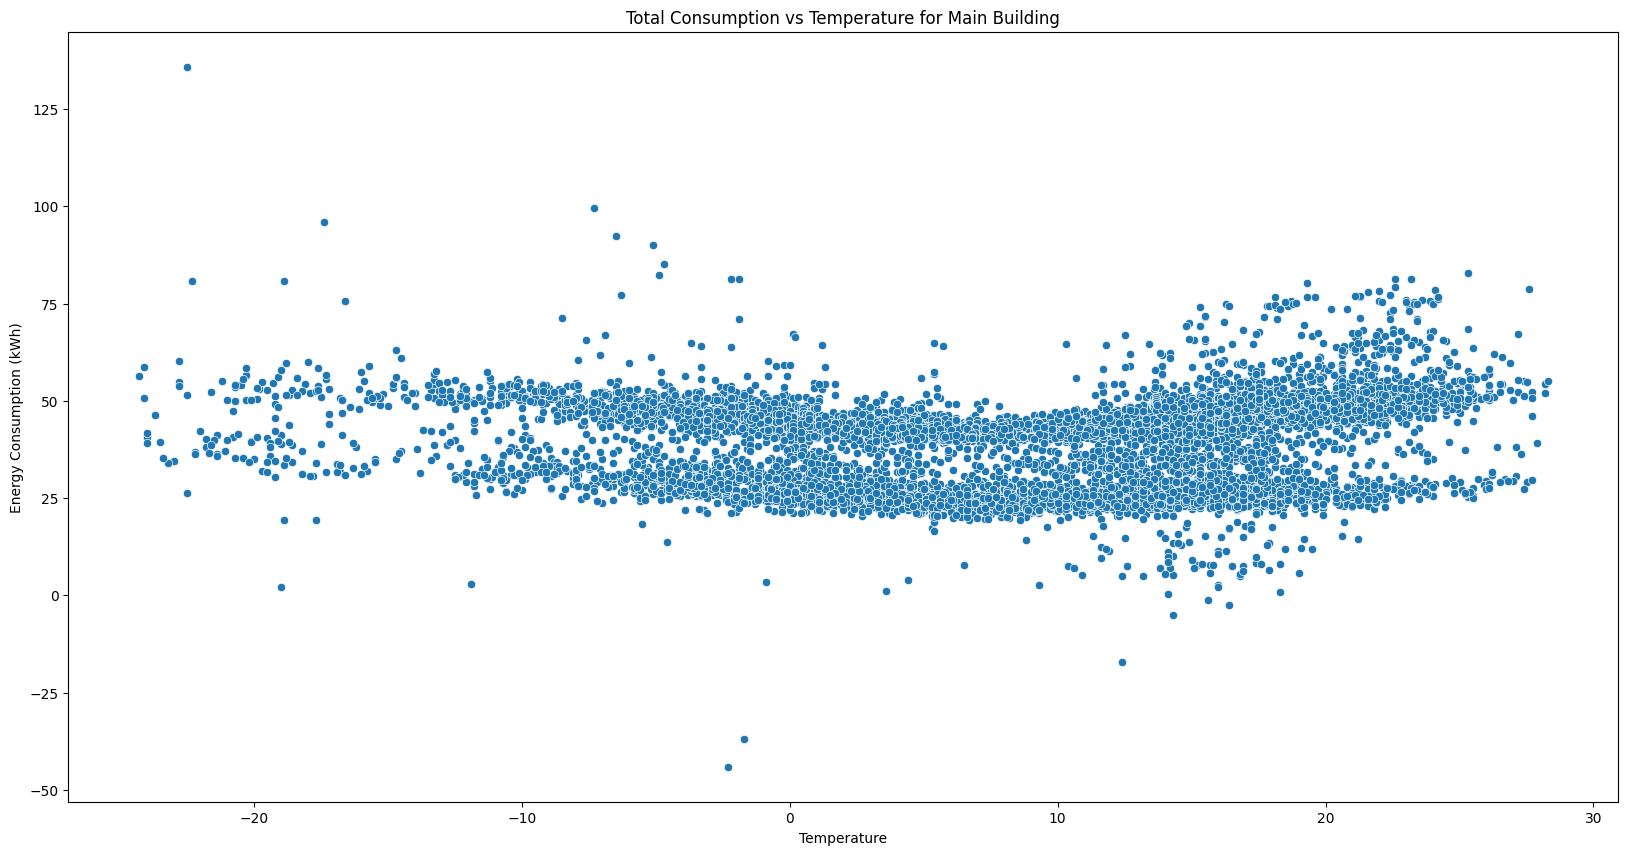

In [143]:
#Plot the temperature with the total consumption for the main building

plt.figure(figsize=(20,10))
sns.scatterplot(data=main_building_df, x='temperature', y='total_consumption')
plt.title('Total Consumption vs Temperature for Main Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Temperature')
plt.show()

### 4. Evaluation

In [149]:
# Load prediction data
pred_df = pd.read_csv('../data/prediciton1.csv')

pred_df.head()

,value
0,27.487604
1,31.133010
2,24.466808
3,18.724820
4,19.054262


In [151]:
# Add a timestamp column that that starts at the same time as the main building data
pred_df['timestamp'] = pd.date_range(start='2023-07-01 00:00:00', periods=len(pred_df), freq='H')
pred_df.set_index('timestamp', inplace=True)

pred_df.head()

,value
timestamp,
2023-07-01 00:00:00,27.487604
2023-07-01 01:00:00,31.133010
2023-07-01 02:00:00,24.466808
2023-07-01 03:00:00,18.724820
2023-07-01 04:00:00,19.054262


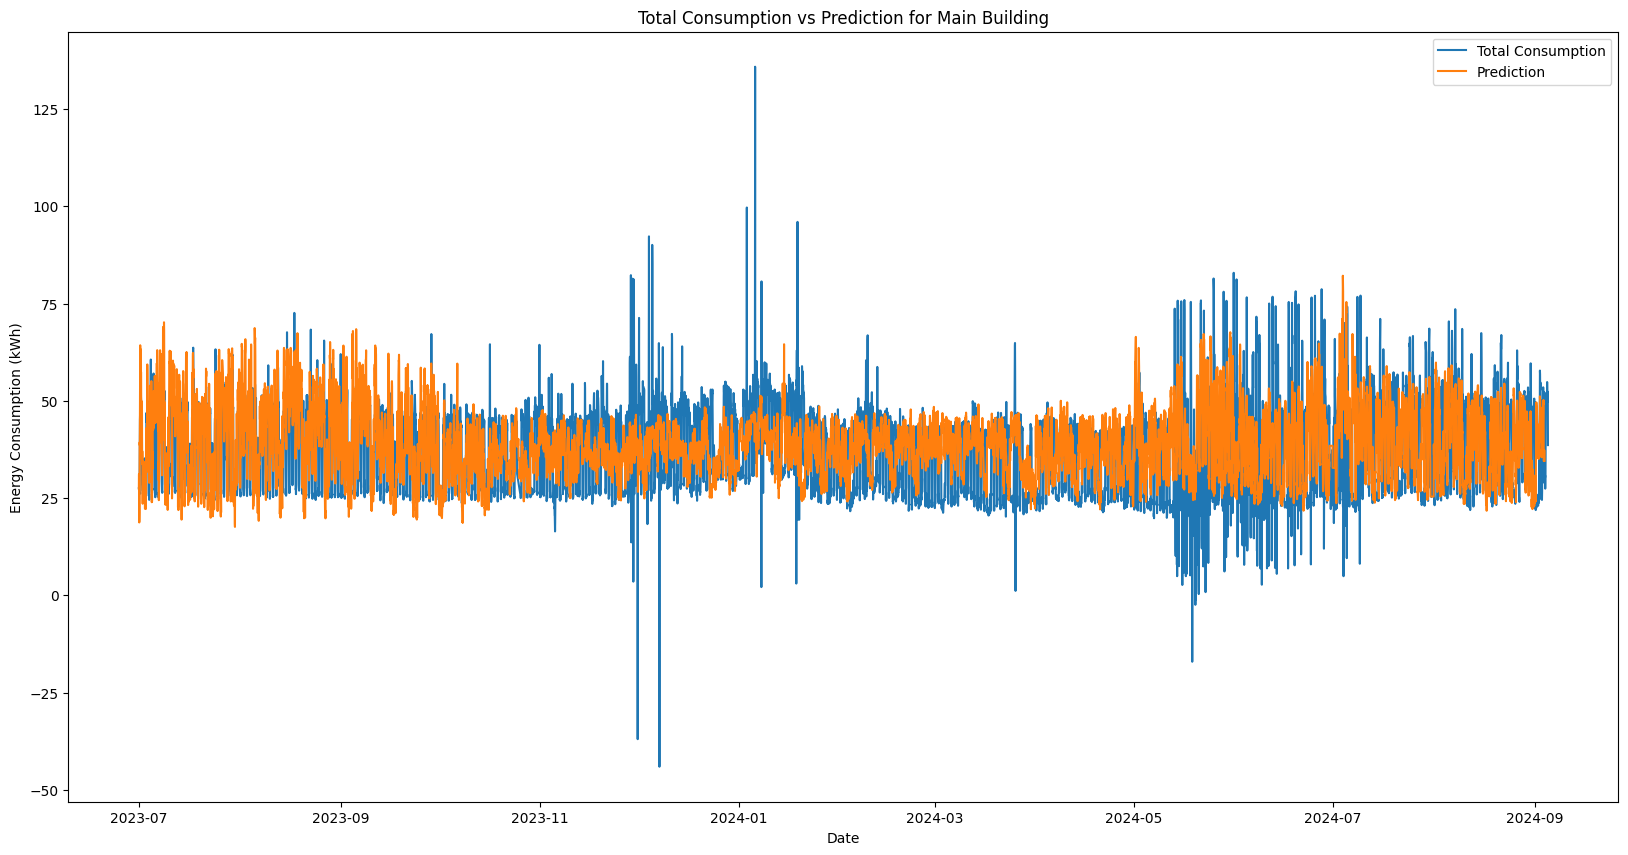

In [153]:
#Plot the prediction data with the main building data

plt.figure(figsize=(20,10))
sns.lineplot(data=main_building_df, x='timestamp', y='total_consumption', label='Total Consumption')
sns.lineplot(data=pred_df, x='timestamp', y='value', label='Prediction')
plt.title('Total Consumption vs Prediction for Main Building')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Date')
plt.show()


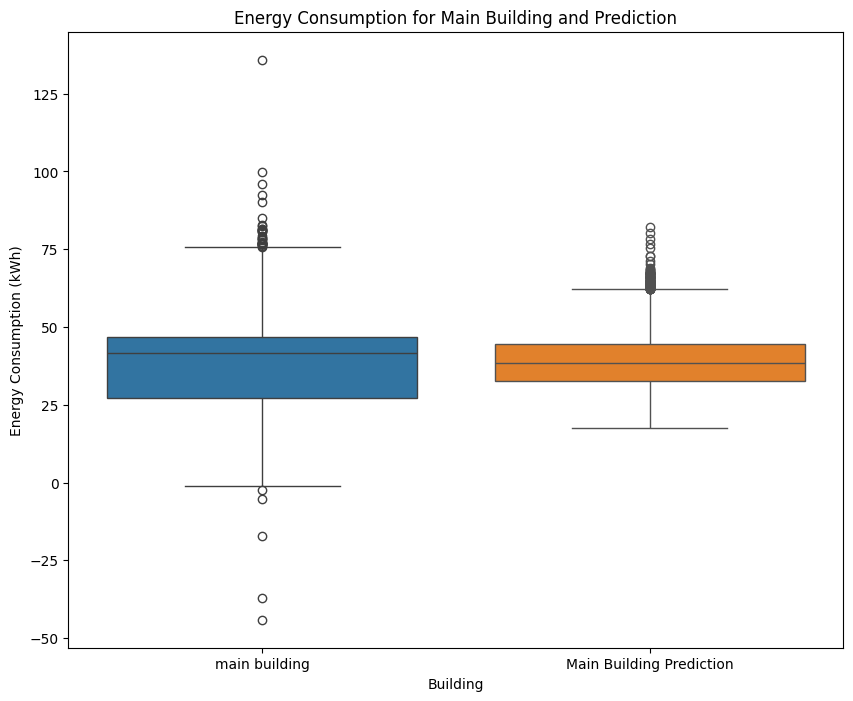

In [160]:
#Plot the prediction data with the main building data in a boxplot

plt.figure(figsize=(10,8))
sns.boxplot(data=main_building_df, x='building', y='total_consumption')
sns.boxplot(data=pred_df, x=['Main Building Prediction'] * len(pred_df), y='value')
plt.title('Energy Consumption for Main Building and Prediction')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()

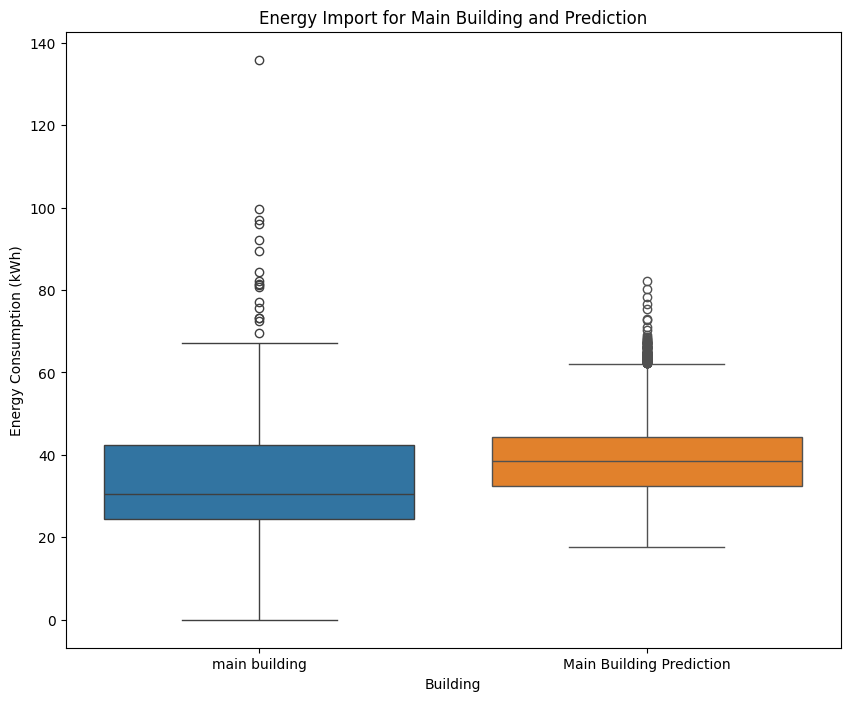

In [161]:
#Plot the prediction data with the main building import data in a boxplot

plt.figure(figsize=(10,8))
sns.boxplot(data=main_building_import_df, x='building', y='value')
sns.boxplot(data=pred_df, x=['Main Building Prediction'] * len(pred_df), y='value')
plt.title('Energy Import for Main Building and Prediction')
plt.ylabel('Energy Consumption (kWh)')
plt.xlabel('Building')
plt.show()